# CAB420 Assignment 1A Question 3

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard import notebook

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

import scipy.io
import numpy
# numpy.set_printoptions(threshold=numpy.inf)

import os
import datetime
import pydot
import IPython
from IPython.display import SVG

# Question 1
Train a model from scratch, using no data augmentation, on the provided abridged
SVHN training set.

In [2]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [3]:
def train_and_eval(model, x_train, y_train, x_test, y_test, filename, batch_size, epochs, class_weights):
    
    checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint],
                        class_weight=class_weights)    
    
    model.load_weights(filename)
    model.save(filename)    
    
    fig = plt.figure(figsize=[30, 10])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Performance')

    
    ax = fig.add_subplot(1, 3, 2)
    pred = model.predict(x_train);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_train, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(1,11))
    c.plot(ax = ax)    
    ax.set_title('Training')
    
    ax = fig.add_subplot(1, 3, 3)
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(1,11))
    c.plot(ax = ax)    
    ax.set_title('Testing')

In [4]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)

    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[15, 5])
    ax = fig.add_subplot(1, 2, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(1,11))
    c.plot(ax = ax)

    ax = fig.add_subplot(1, 2, 2)
    ax.hist(y_test, bins=len(numpy.diagonal(cm)), rwidth=0.95)
    ax.plot(numpy.diagonal(cm))

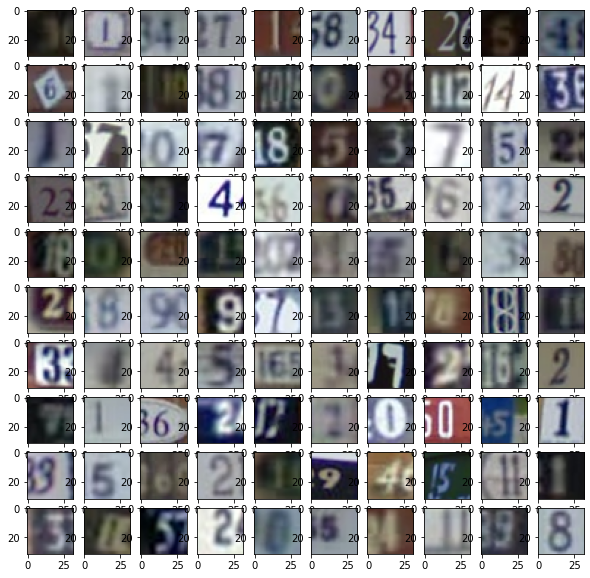

In [5]:
SVHN_train = scipy.io.loadmat(r'C:\Users\under\OneDrive\Documents\CAB420\CAB420_Assessment1A_Data\Data\Q3\q3_train.mat')
SVHN_test = scipy.io.loadmat(r'C:\Users\under\OneDrive\Documents\CAB420\CAB420_Assessment1A_Data\Data\Q3\q3_test.mat')
# print(SVHN_test)
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(SVHN_train['train_X'][:,:,:,i])

In [6]:
# Change class from [1 - 10] to [0 - 9] as keras takes 0 - 9

for i in range (len(SVHN_train['train_Y'])):
    SVHN_train['train_Y'][i] = SVHN_train['train_Y'][i] - 1
for i in range (len(SVHN_test['test_Y'])):
    SVHN_test['test_Y'][i] = SVHN_test['test_Y'][i] - 1


In [7]:
# Do we need to preserve rbg value(3) in a 4D, or just put 1 in the end
train = numpy.transpose(SVHN_train['train_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3)
train_y = SVHN_train['train_Y']
test = numpy.transpose(SVHN_test['test_X'], (3, 0, 1, 2)).reshape(-1, 32, 32, 3)
test_y = SVHN_test['test_Y']

class_weights = class_weight.compute_class_weight('balanced',
                                                 numpy.unique(train_y.flatten()),
                                                 train_y.flatten())

Train on 1000 samples, validate on 10000 samples
Epoch 1/30
1000/1000 [==============================] - 2s 2ms/sample - loss: 49.9122 - accuracy: 0.0840 - val_loss: 7.5230 - val_accuracy: 0.1347
Epoch 2/30
1000/1000 [==============================] - 2s 2ms/sample - loss: 4.8805 - accuracy: 0.1490 - val_loss: 3.8676 - val_accuracy: 0.1456
Epoch 3/30
1000/1000 [==============================] - 2s 2ms/sample - loss: 3.0924 - accuracy: 0.1970 - val_loss: 3.2849 - val_accuracy: 0.1672
Epoch 4/30
1000/1000 [==============================] - 2s 2ms/sample - loss: 2.5001 - accuracy: 0.2530 - val_loss: 3.2220 - val_accuracy: 0.1551
Epoch 5/30
1000/1000 [==============================] - 2s 2ms/sample - loss: 2.2052 - accuracy: 0.3010 - val_loss: 2.9429 - val_accuracy: 0.1959
Epoch 6/30
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.9629 - accuracy: 0.3690 - val_loss: 2.8361 - val_accuracy: 0.1987
Epoch 7/30
1000/1000 [==============================] - 2s 2ms/sample - lo

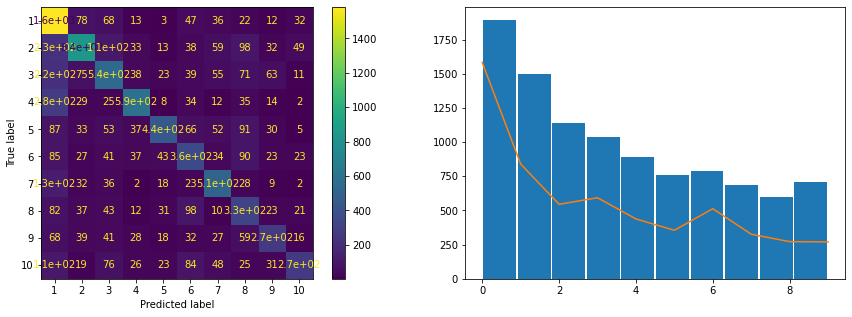

In [8]:
def build_model(num_classes):
    # our model, input in an image shape
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    # flatten layer
    x = layers.Flatten()(x)
  
    # the output
    outputs = layers.Dense(num_classes)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='model_attempt_1')
    
    return model_cnn
model_attempt_1 = build_model(10)
model_attempt_1.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
history = model_attempt_1.fit(train, train_y,
                        batch_size=128,
                        epochs=30,
                        validation_data=(test, test_y),
                             )
eval_model(model_attempt_1, test, test_y)

Text(0.5, 1.0, 'Training Performance')

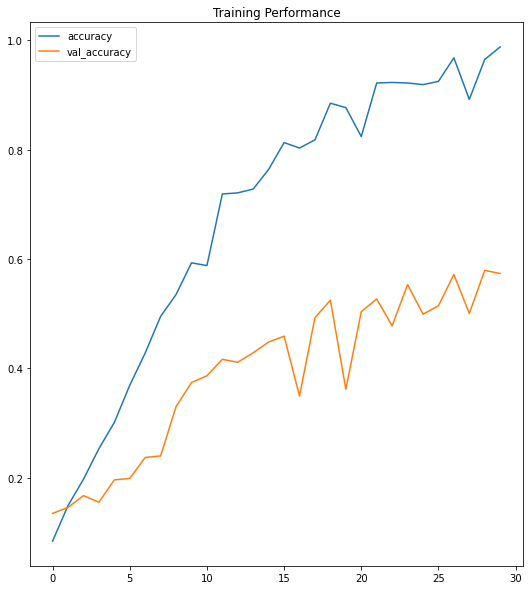

In [22]:
fig = plt.figure(figsize=[30, 10])
ax = fig.add_subplot(1, 3, 1)
# plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
ax.legend()
ax.set_title('Training Performance')

### vgg_2stage_SVHN_big Results

Train on 1000 samples, validate on 10000 samples
Epoch 1/60
 896/1000 [=========================>....] - ETA: 0s - loss: 2.6350 - accuracy: 0.1083
Epoch 00001: val_loss improved from inf to 3.14410, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 8s 8ms/sample - loss: 2.6116 - accuracy: 0.1130 - val_loss: 3.1441 - val_accuracy: 0.1141
Epoch 2/60
 896/1000 [=========================>....] - ETA: 0s - loss: 2.4548 - accuracy: 0.1496
Epoch 00002: val_loss improved from 3.14410 to 2.56865, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 6s 6ms/sample - loss: 2.4466 - accuracy: 0.1540 - val_loss: 2.5687 - val_accuracy: 0.1167
Epoch 3/60
 896/1000 [=========================>....] - ETA: 0s - loss: 2.3274 - accuracy: 0.2054
Epoch 00003: val_loss did not improve from 2.56865
1000/1000 [==============================] - 5s 5ms/sample - loss: 2.3155 - accuracy: 0.2100 - val_loss: 3.0610 - val_accuracy: 0.1045
Epoch 4/60
 896

 896/1000 [=========================>....] - ETA: 0s - loss: 0.4638 - accuracy: 0.8605
Epoch 00026: val_loss improved from 0.93195 to 0.88803, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.4631 - accuracy: 0.8570 - val_loss: 0.8880 - val_accuracy: 0.7313
Epoch 27/60
 896/1000 [=========================>....] - ETA: 0s - loss: 0.4494 - accuracy: 0.8650
Epoch 00027: val_loss improved from 0.88803 to 0.87232, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.4512 - accuracy: 0.8640 - val_loss: 0.8723 - val_accuracy: 0.7329
Epoch 28/60
 896/1000 [=========================>....] - ETA: 0s - loss: 0.3660 - accuracy: 0.9040
Epoch 00028: val_loss improved from 0.87232 to 0.79939, saving model to vgg_2stage_SVHN_big.h5
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.3839 - accuracy: 0.8970 - val_loss: 0.7994 - val_accuracy: 0.7472
Epoch 29/60
 896/1000 [==

Epoch 54/60
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0784 - accuracy: 0.9777
Epoch 00054: val_loss did not improve from 0.77419
1000/1000 [==============================] - 6s 6ms/sample - loss: 0.0748 - accuracy: 0.9790 - val_loss: 0.8918 - val_accuracy: 0.7712
Epoch 55/60
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0916 - accuracy: 0.9766
Epoch 00055: val_loss did not improve from 0.77419
1000/1000 [==============================] - 6s 6ms/sample - loss: 0.0877 - accuracy: 0.9790 - val_loss: 0.8632 - val_accuracy: 0.7766
Epoch 56/60
 896/1000 [=========================>....] - ETA: 0s - loss: 0.1030 - accuracy: 0.9665
Epoch 00056: val_loss did not improve from 0.77419
1000/1000 [==============================] - 6s 6ms/sample - loss: 0.1038 - accuracy: 0.9660 - val_loss: 0.9227 - val_accuracy: 0.7750
Epoch 57/60
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0776 - accuracy: 0.9833
Epoch 00057: val_loss did not improve from 0.7

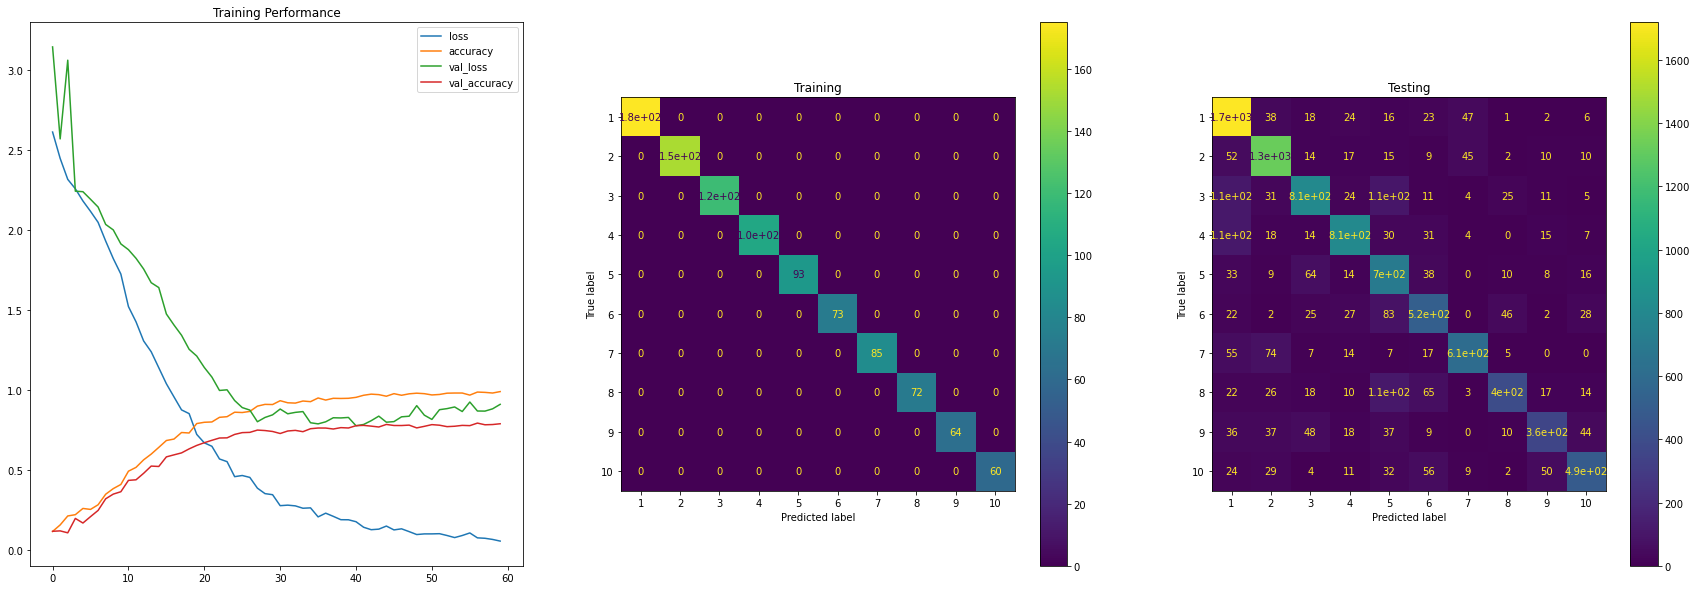

In [10]:
batch_size = 128
num_epochs = 60
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [8,16,32], [256, 128], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, train, train_y, test, test_y, 'vgg_2stage_SVHN_big.h5', batch_size, num_epochs, class_weights)

10000/10000 - 4s - loss: 0.7742 - accuracy: 0.7747
Test loss: 0.7741941264152526
Test accuracy: 0.7747


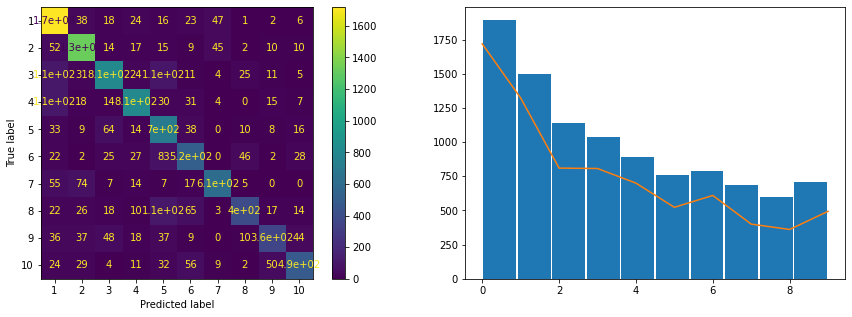

In [11]:
eval_model(model_cnn, test, test_y)

### vgg_3stage_SVHN_big Results

Train on 1000 samples, validate on 10000 samples
Epoch 1/35
 896/1000 [=========================>....] - ETA: 0s - loss: 2.6701 - accuracy: 0.1429
Epoch 00001: val_loss improved from inf to 2.71288, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 12s 12ms/sample - loss: 2.6504 - accuracy: 0.1470 - val_loss: 2.7129 - val_accuracy: 0.0635
Epoch 2/35
 896/1000 [=========================>....] - ETA: 0s - loss: 2.2722 - accuracy: 0.2188
Epoch 00002: val_loss improved from 2.71288 to 2.58718, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 11s 11ms/sample - loss: 2.2690 - accuracy: 0.2200 - val_loss: 2.5872 - val_accuracy: 0.1018
Epoch 3/35
 896/1000 [=========================>....] - ETA: 0s - loss: 2.2048 - accuracy: 0.2355
Epoch 00003: val_loss improved from 2.58718 to 2.38290, saving model to vgg_3stage_SVHN_big.h5
1000/1000 [==============================] - 11s 11ms/sample - loss: 2.2092 - accuracy: 0.2400 - val_l

 896/1000 [=========================>....] - ETA: 0s - loss: 0.0687 - accuracy: 0.9888
Epoch 00026: val_loss did not improve from 0.67256
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.0685 - accuracy: 0.9890 - val_loss: 0.6837 - val_accuracy: 0.7916
Epoch 27/35
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0657 - accuracy: 0.9855
Epoch 00027: val_loss did not improve from 0.67256
1000/1000 [==============================] - 13s 13ms/sample - loss: 0.0646 - accuracy: 0.9860 - val_loss: 0.6815 - val_accuracy: 0.7941
Epoch 28/35
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0651 - accuracy: 0.9888
Epoch 00028: val_loss did not improve from 0.67256
1000/1000 [==============================] - 14s 14ms/sample - loss: 0.0672 - accuracy: 0.9880 - val_loss: 0.6775 - val_accuracy: 0.7942
Epoch 29/35
 896/1000 [=========================>....] - ETA: 0s - loss: 0.0707 - accuracy: 0.9799
Epoch 00029: val_loss improved from 0.67256 to 0.669

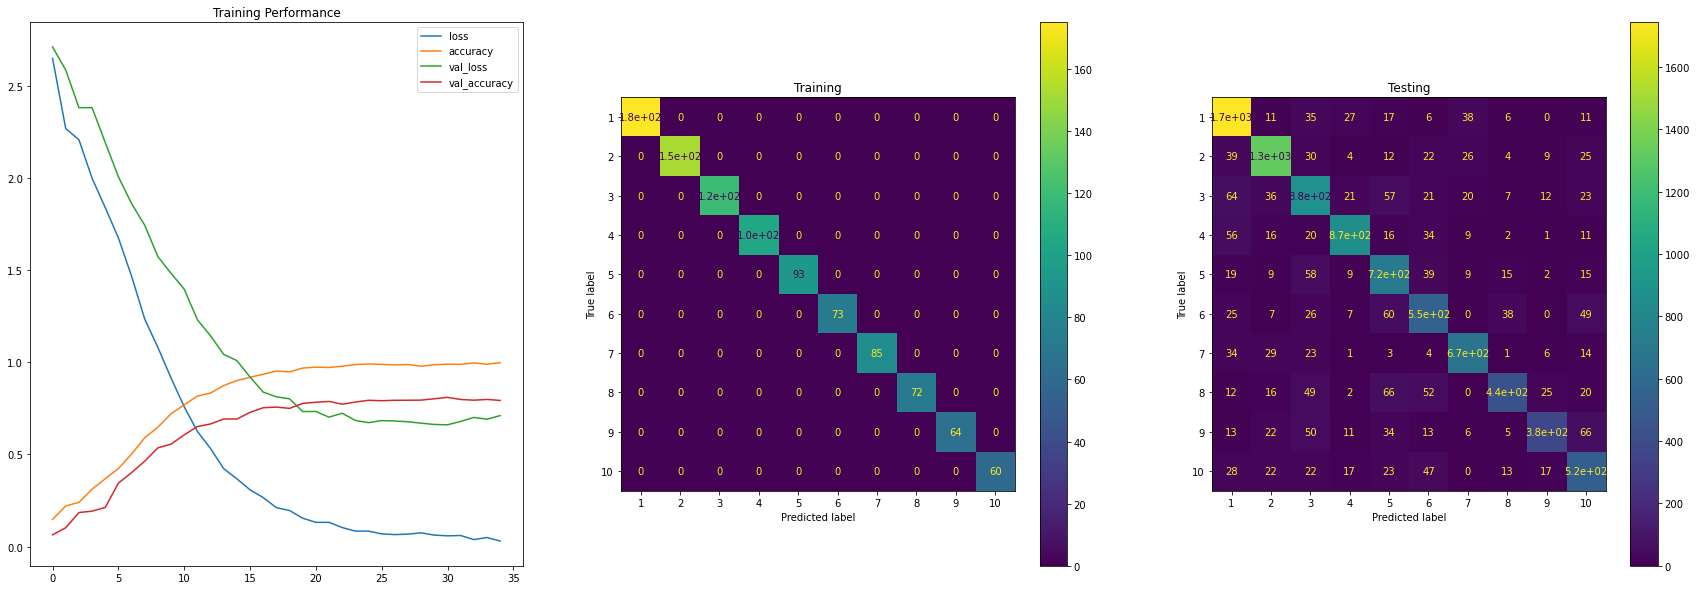

In [12]:
num_epochs = 35
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16,32,64], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_3stage_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_3stage_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
train_and_eval(model_3stage_cnn, train, train_y, test, test_y, 'vgg_3stage_SVHN_big.h5', batch_size, num_epochs, class_weights)

10000/10000 - 12s - loss: 0.6607 - accuracy: 0.8099
Test loss: 0.6607338624238968
Test accuracy: 0.8099


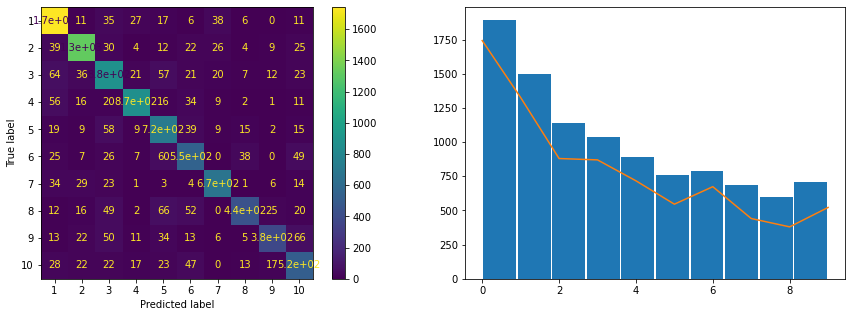

In [13]:
eval_model(model_3stage_cnn, test, test_y)

# Question 2
Train a model from scratch, using the data augmentation of your choice, on the provided abridged SVHN training set.

In [23]:
datagen = ImageDataGenerator(
                            # rotate between -5, +5 degrees
                            rotation_range=5,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for randomly applying a shearing transform
                            shear_range=0.05,
                            # range for zooming
                            zoom_range=0.05,
                            # don't allow horizontal flips of data
                            horizontal_flip=False,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

In [24]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [8,16,32], [256, 128], 0.2, 0.2)
output = layers.Dense(10)(x)
model_augmented_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_augmented_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


history_aug = model_augmented_cnn.fit_generator(datagen.flow(train, train_y, batch_size=128),
                    steps_per_epoch=1000//128,
                    epochs=100,
                    validation_data=(test, test_y), verbose=False,
                                           class_weight=class_weights)      

  ...
    to  
  ['...']


10000/10000 - 4s - loss: 0.6026 - accuracy: 0.8245
Test loss: 0.6026449048519135
Test accuracy: 0.8245


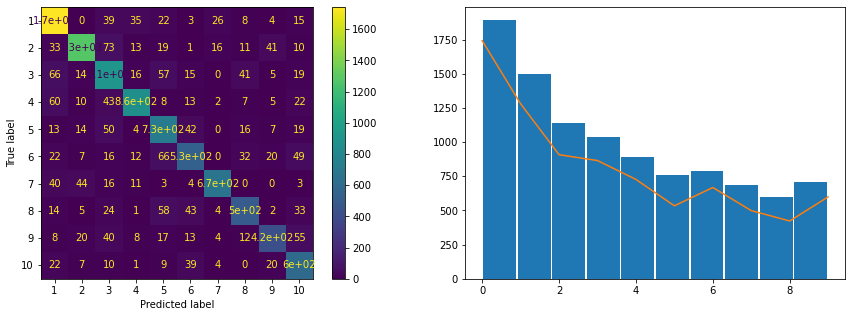

In [25]:
eval_model(model_augmented_cnn, test, test_y)

Text(0.5, 1.0, 'Training Performance')

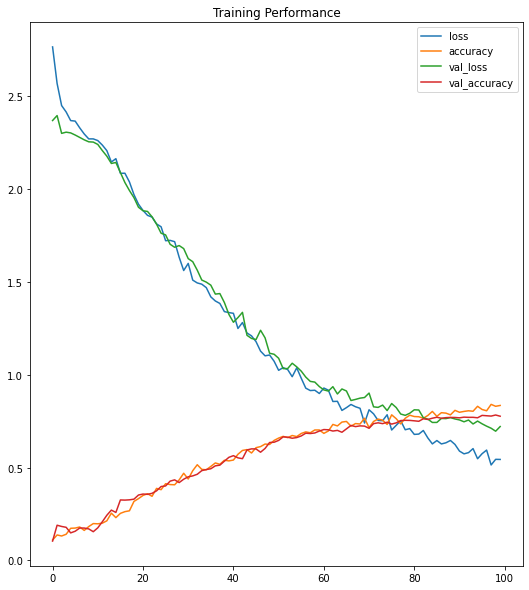

In [17]:
fig = plt.figure(figsize=[30, 10])
ax = fig.add_subplot(1, 3, 1)
plt.plot(history_aug.history['loss'], label='loss')
plt.plot(history_aug.history['accuracy'], label='accuracy')
plt.plot(history_aug.history['val_loss'], label='val_loss')
plt.plot(history_aug.history['val_accuracy'], label='val_accuracy')
ax.legend()
ax.set_title('Training Performance')

In [18]:
model_attempt_1.summary()

Model: "model_attempt_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                40970     
Total params: 42,362
Trainable params: 42,362
Non-trainable params: 0
_______________________________________________

In [26]:
model_3stage_cnn.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0

In [27]:
model_augmented_cnn.summary()

Model: "simple_vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 8)         0         
_________________________________________________________________
spatial_dropout2d_9 (Spatial (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 8)         0